### 1. Imports
Import all the libraries and modules needed

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import shap

### 2. Load Dataset
Read and store the dataset in a dataframe (`df`)

In [2]:
df = pd.read_csv("./databases/StudentsAdaptabilityLevel/students_adaptability_level_online_education.csv")

### 3. Preprocessing

#### 3.1 Target Variable
Extract `Adaptivity Level` as the target vector `y`, and construct the feature matrix `X` by dropping the `Adaptivity Level` column from `df`.

In [3]:
X = df.drop(columns=["Adaptivity Level"])
y = df["Adaptivity Level"]

#### 3.2 Dummy Encoding
Convert all categorical predictors into binary indicator columns.

In [4]:
X = pd.get_dummies(X, drop_first=True)

#### 3.3 Train–Test Split
Split the feature matrix `X` and target vector `y` into training (80%) and testing (20%) subsets, using `random_state=42` to ensure reproducible results.  

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Logistic Regression
In this step, we build and assess a logistic regression classifier by:  
1. **Initialize Model**: Create a `LogisticRegression` instance with default settings
2. **Train Model**: Fit the classifier on the training data (`X_train`, `y_train`)
3. **Make Predictions**: Use the trained model to predict dropout labels for the test set (`X_test`)
4. **Evaluate Performance**: Generate a classification report detailing precision, recall, and F1‐scores by comparing `y_test` with the predicted labels (`log_reg_y_pred`)

In [6]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_y_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.48      0.61        23
         Low       0.76      0.66      0.70       103
    Moderate       0.70      0.83      0.76       115

    accuracy                           0.73       241
   macro avg       0.77      0.66      0.69       241
weighted avg       0.74      0.73      0.72       241



#### 4.1 Logistic Regression Coefficients
Extract the logistic regression coefficients, take their absolute values, and sort features by magnitude to rank their influence

In [7]:
# Feature Importance with Coefficients
importance = pd.DataFrame({
    'feature': X_train.columns,
    #'coefficient': log_reg.coef_[0],
    'mean_abs_coef': np.mean(np.abs(log_reg.coef_), axis=0)
})
importance = importance.sort_values(by='mean_abs_coef', ascending=False).reset_index(drop=True)

#### 4.2 Visualize Coefficients
Create a horizontal bar chart of the top 10 features coefficients from the logistic regression model to compare their relative impacts

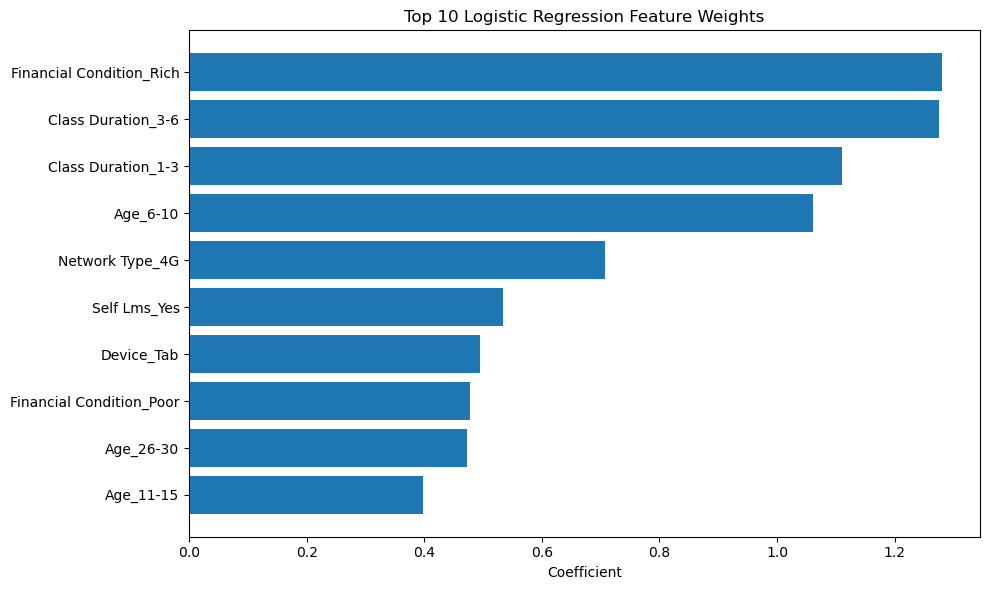

In [8]:
plt.figure(figsize=(10,6))
plt.barh(
    importance['feature'].head(10)[::-1],
    importance['mean_abs_coef'].head(10)[::-1]
)
plt.xlabel('Coefficient')
plt.title('Top 10 Logistic Regression Feature Weights')
plt.tight_layout()
plt.savefig('./images/StudentsAdaptabilityLevel/logreg_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Decision Tree
In this step, we build and assess a decision tree classifier by:  
1. **Initialize Model**: Create a `DecisionTreeClassifier` with `random_state=42`
2. **Train Model**: Fit the classifier on `X_train` and `y_train`
3. **Make Predictions**: Predict dropout labels for `X_test`
4. **Evaluate Performance**: Generate a classification report to summarize precision, recall, and F1-scores

In [9]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_y_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.65      0.75        23
         Low       0.92      0.94      0.93       103
    Moderate       0.90      0.92      0.91       115

    accuracy                           0.90       241
   macro avg       0.90      0.84      0.86       241
weighted avg       0.90      0.90      0.90       241



#### 5.1 Gini Impurity
Extract the `feature_importances_` from the trained decision tree and pair them with feature names to rank predictors by their Gini-based importance.

In [10]:
# Feature Importance with Gini
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt.feature_importances_
})

#### 5.2 Plot Gini Importances
Create a horizontal bar chart of the top 10 features ranked by their Gini-based importance from the decision tree model.

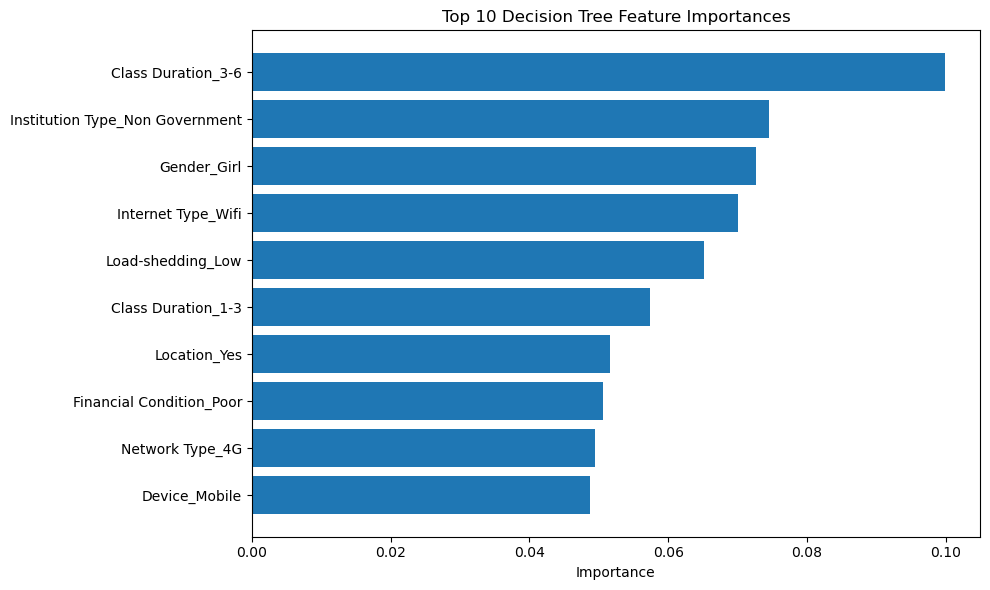

In [11]:
importance = importance.sort_values(by='importance', ascending=False)
top10 = importance.head(10)[::-1]
plt.figure(figsize=(10,6))
plt.barh(top10['feature'], top10['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Decision Tree Feature Importances')
plt.tight_layout()
plt.savefig('./images/StudentsAdaptabilityLevel/dt_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### 6. Random Forest
In this step, we build and assess a random forest classifier by:  
1. **Initialize Model**: Create a `RandomForestClassifier` with 100 trees, `random_state=42`
2. **Train Model**: Fit the classifier on `X_train` and `y_train`
3. **Make Predictions**: Predict dropout labels for `X_test`
4. **Evaluate Performance**: Generate a classification report to summarize precision, recall, and F1-scores

In [12]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train.values, y_train)

# Predict and evaluate
rf_y_pred  = rf.predict(X_test.values)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

        High       0.88      0.65      0.75        23
         Low       0.93      0.94      0.94       103
    Moderate       0.90      0.94      0.92       115

    accuracy                           0.91       241
   macro avg       0.91      0.84      0.87       241
weighted avg       0.91      0.91      0.91       241



### 6.1 Permutation Importance
Assess feature relevance by measuring the drop in model performance when each feature is randomly shuffled over multiple repeats, then average and rank features by their mean importance and store it in a dataframe.

In [13]:
# Permutation Importance
result = permutation_importance(
    rf, X_test.values, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=2
)
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': result.importances_mean
})

#### 6.2 Plot Permutation Importance
Create a horizontal bar chart of the top 10 features ranked by their permutation importance to visualize which predictors most affect the random forest’s performance.

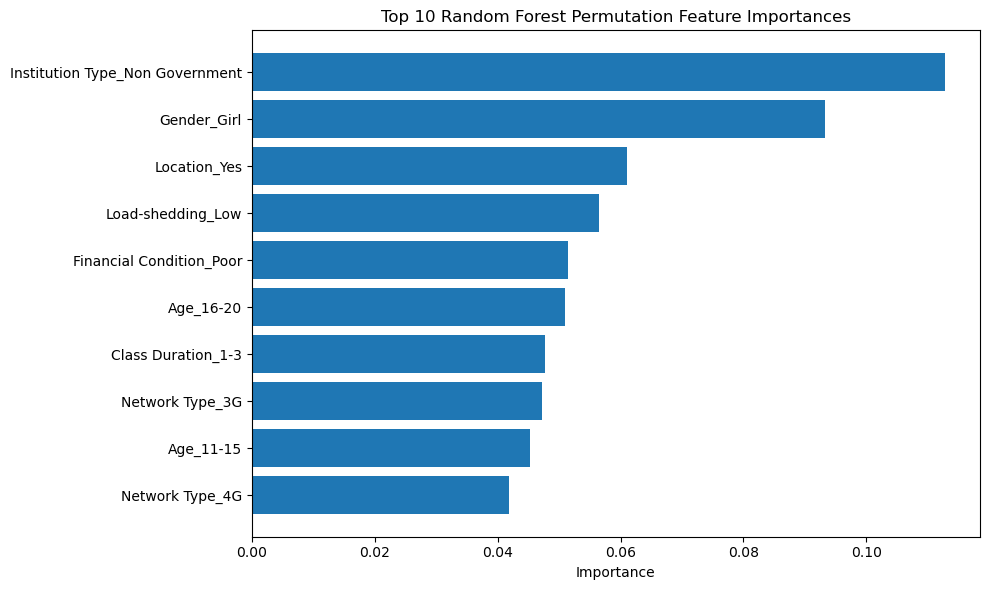

In [14]:
importance = importance.sort_values(by='importance', ascending=False)
top10 = importance.head(10)[::-1]
plt.figure(figsize=(10,6))
plt.barh(top10['feature'], top10['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Random Forest Permutation Feature Importances')
plt.tight_layout()
plt.savefig('./images/StudentsAdaptabilityLevel/rf_permutation_feature_importance.png', dpi=300, bbox_inches='tight')

### 6.3 Lime
Initialize a `LimeTabularExplainer` on the random forest training data and feature names, select the i = 0 test instance, and generate a local explanation via `explain_instance()`

In [15]:
# LIME
explainer = LimeTabularExplainer(
    training_data=X_train.values.astype(float),
    feature_names=X_train.columns,
    class_names=rf.classes_,
    mode='classification'
)
i = 0
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values.astype(float),
    predict_fn=rf.predict_proba,
)

#### 6.4 LIME Visualization
Display the local explanation for the selected test instance i = 0 as a table and a static matplotlib plot

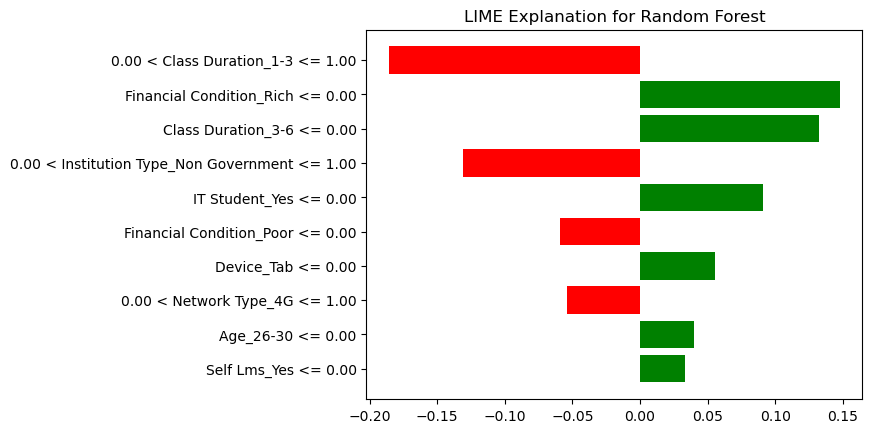

In [16]:
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.title('LIME Explanation for Random Forest')
plt.savefig('./images/StudentsAdaptabilityLevel/rf_lime_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.5 SHAP
Initialize a SHAP explainer for the random forest model and compute SHAP values for the test set (`X_test`)

In [17]:
# SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)

#### 6.6 SHAP Visualization Globally
Create a summary bar plot of SHAP values to interpret feature importance globally

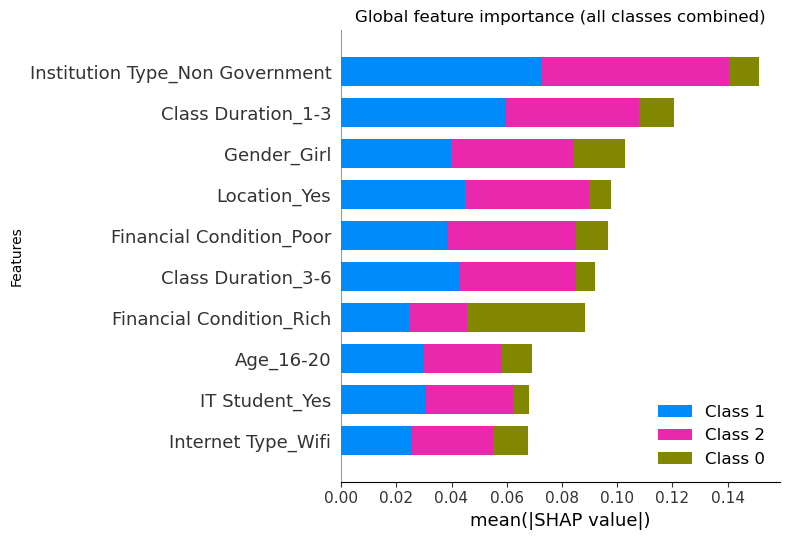

In [18]:
# Global SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.title("Global feature importance (all classes combined)")
plt.xlabel("mean(|SHAP value|)")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig('./images/StudentsAdaptabilityLevel/rf_global_shap.png', dpi=300, bbox_inches='tight')
plt.show()

#### 6.7 SHAP Visualization Globally for each class
Create bar plots of SHAP values to interpret feature importance globally for each class Low, Medium and High

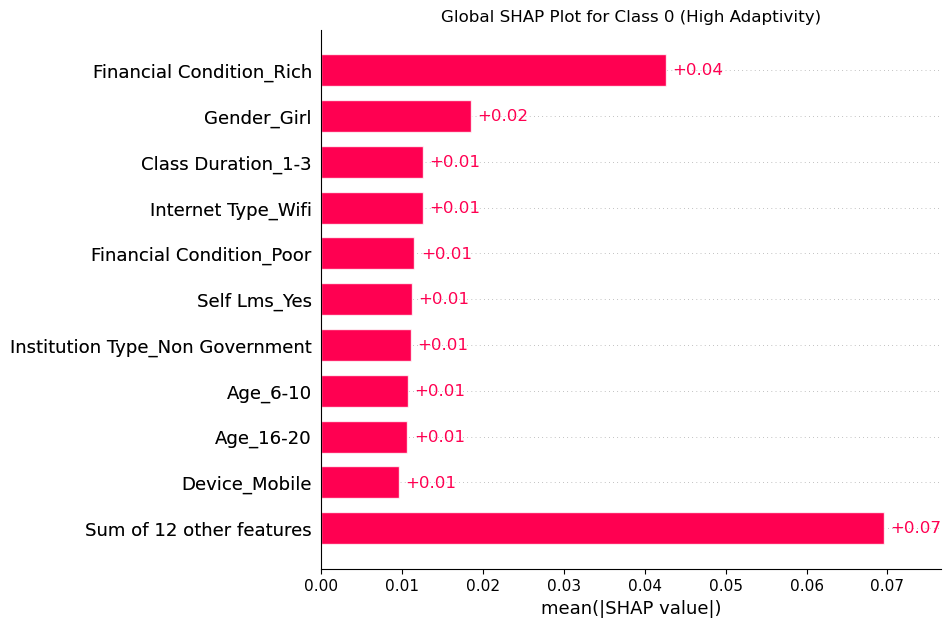

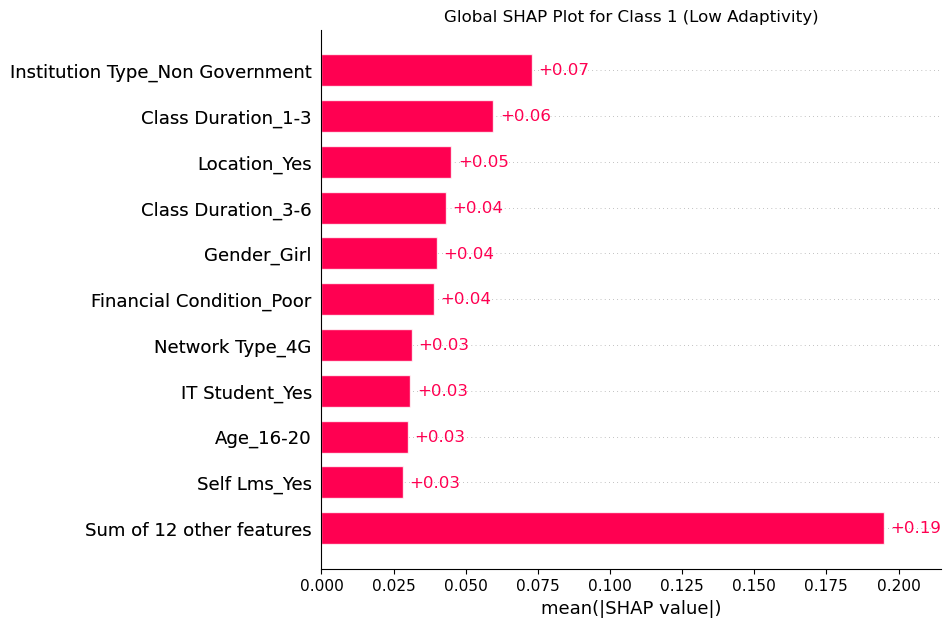

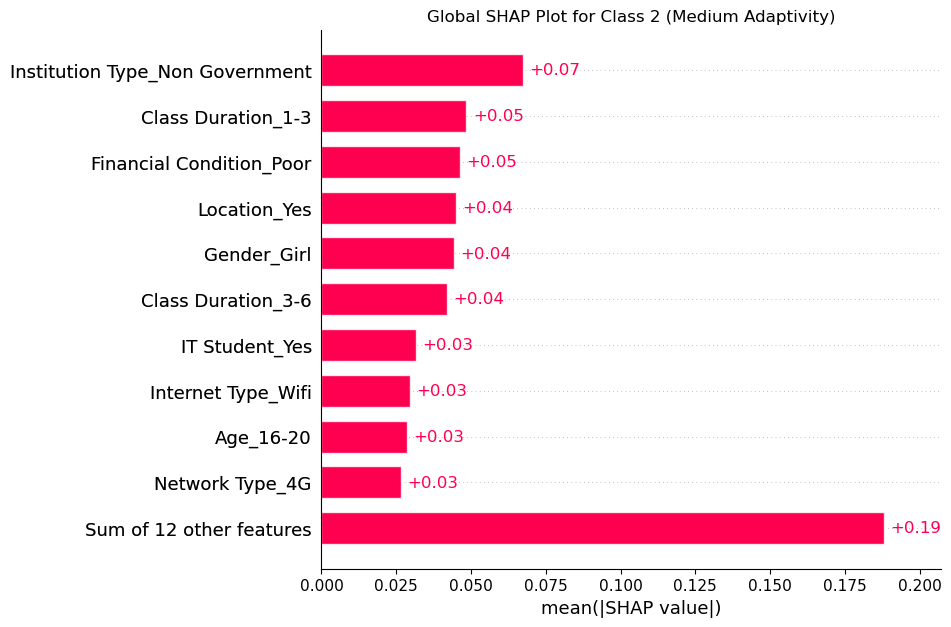

In [19]:
# Global SHAP for each class
plt.title("Global SHAP Plot for Class 0 (High Adaptivity)")
shap.plots.bar(shap_values[:,:,0], max_display=11, show=False)
plt.savefig('./images/StudentsAdaptabilityLevel/rf_global_shap_class0.png', dpi=300, bbox_inches='tight')
plt.show()
plt.title("Global SHAP Plot for Class 1 (Low Adaptivity)")
shap.plots.bar(shap_values[:,:,1], max_display=11, show=False)
plt.savefig('./images/StudentsAdaptabilityLevel/rf_global_shap_class1.png', dpi=300, bbox_inches='tight')
plt.show()
plt.title("Global SHAP Plot for Class 2 (Medium Adaptivity)")
shap.plots.bar(shap_values[:,:,2], max_display=11, show=False)
plt.savefig('./images/StudentsAdaptabilityLevel/rf_global_shap_class2.png', dpi=300, bbox_inches='tight')
plt.show()

#### 6.8 SHAP Visualization Locally for each class
Create bar plots of SHAP values to interpret feature importance locally for each class Low, Medium and High

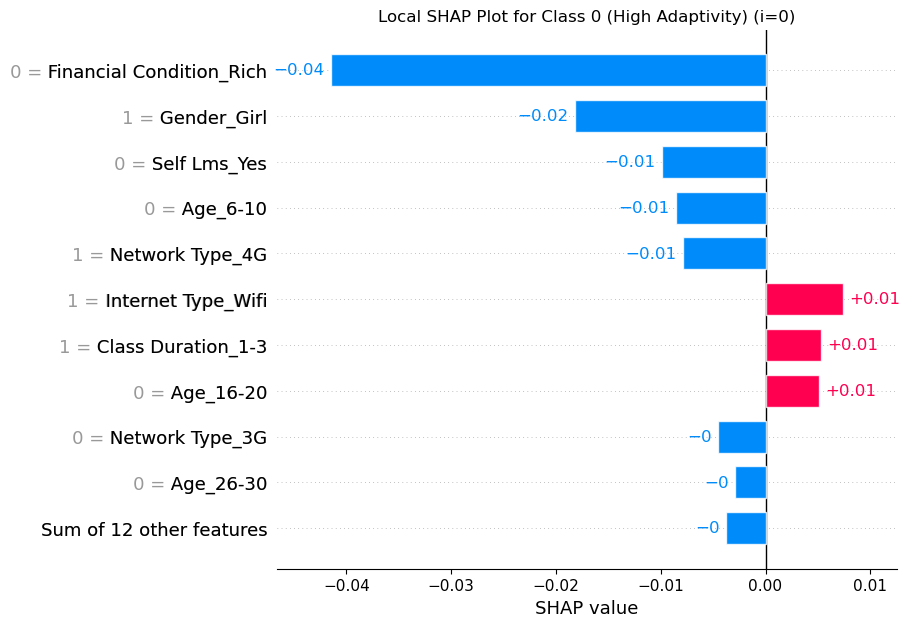

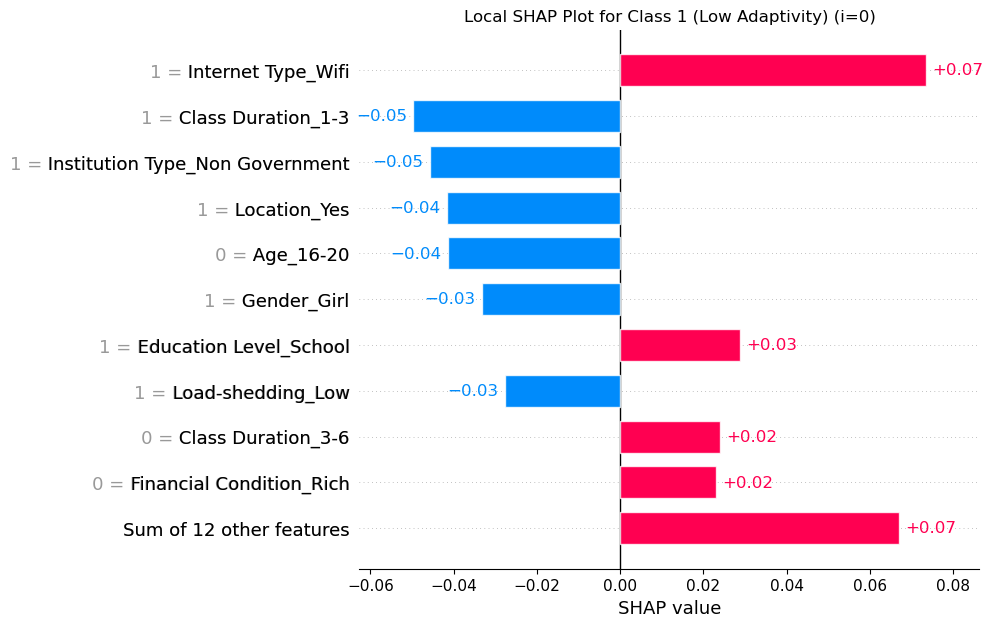

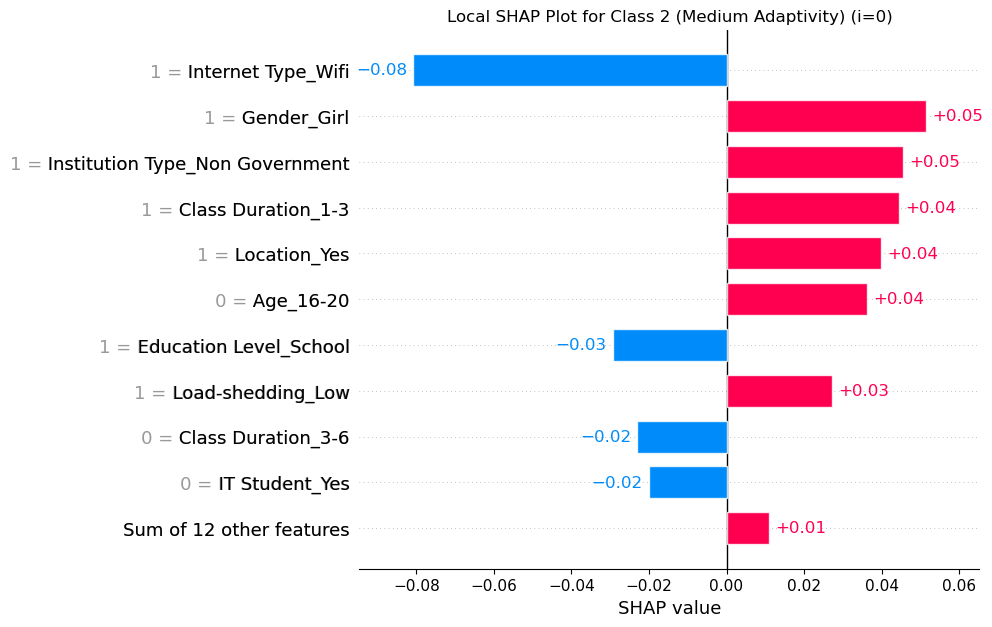

In [20]:
# Local SHAP
plt.title("Local SHAP Plot for Class 0 (High Adaptivity) (i=0)")
shap.plots.bar(shap_values[0,:,0], max_display=11, show=False)
plt.savefig('./images/StudentsAdaptabilityLevel/rf_local_shap_class0_i0.png', dpi=300, bbox_inches='tight')
plt.show()
plt.title("Local SHAP Plot for Class 1 (Low Adaptivity) (i=0)")
shap.plots.bar(shap_values[0,:,1], max_display=11, show=False)
plt.savefig('./images/StudentsAdaptabilityLevel/rf_local_shap_class1_i0.png', dpi=300, bbox_inches='tight')
plt.show()
plt.title("Local SHAP Plot for Class 2 (Medium Adaptivity) (i=0)")
shap.plots.bar(shap_values[0,:,2], max_display=11, show=False)
plt.savefig('./images/StudentsAdaptabilityLevel/rf_local_shap_class2_i0.png', dpi=300, bbox_inches='tight')
plt.show()



### 7. Performance Summary
Generate a per‐class precision/recall/F1 report for each model and compile an overall accuracy table for side-by-side comparison of Logistic Regression, Decision Tree, and Random Forest.  

In [21]:
def concise_report(y_true, y_pred, model_name='Placeholder'):
    # get the full report as a dict
    rpt = classification_report(y_true, y_pred, output_dict=True)
    # turn into DataFrame and transpose so classes are rows
    df = pd.DataFrame(rpt).T
    # drop rows we don’t want
    df = df.drop(index=['accuracy', 'macro avg', 'weighted avg'])
    # name the report
    df.columns = pd.MultiIndex.from_product([[model_name], df.columns])
    return df.round(2)

display(concise_report(y_test, log_reg_y_pred,   model_name='Logistic Regression'))
display(concise_report(y_test, dt_y_pred,   model_name='Decision Tree'))
display(concise_report(y_test, rf_y_pred,   model_name='Random Forest'))

# Accuracy
df_accuracy = pd.DataFrame({
    'Logistic Regression': [accuracy_score(y_test, log_reg_y_pred)],
    'Decision Tree': [accuracy_score(y_test, dt_y_pred)],
    'Random Forest': [accuracy_score(y_test, rf_y_pred)]
}, index=['Accuracy']).T
display(df_accuracy.round(2))

Logistic Regression                        
                   precision recall f1-score support
High                    0.85   0.48     0.61    23.0
Low                     0.76   0.66     0.70   103.0
Moderate                0.70   0.83     0.76   115.0

Decision Tree                        
             precision recall f1-score support
High              0.88   0.65     0.75    23.0
Low               0.92   0.94     0.93   103.0
Moderate          0.90   0.92     0.91   115.0

Random Forest                        
             precision recall f1-score support
High              0.88   0.65     0.75    23.0
Low               0.93   0.94     0.94   103.0
Moderate          0.90   0.94     0.92   115.0

,Accuracy
Logistic Regression,0.73
Decision Tree,0.90
Random Forest,0.91
